In [34]:
import random
from typing import cast

from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import torch
import torch.nn as nn

%matplotlib inline

In [35]:
np.random.seed(1337)
random.seed(1337)

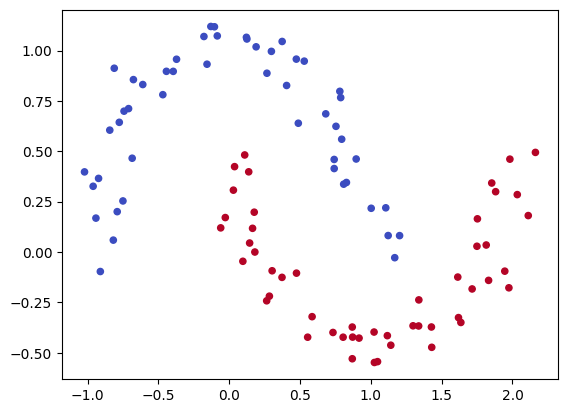

In [36]:
# Create data
X_data, y_data = make_moons(n_samples=100, noise=0.1)
X = torch.tensor(X_data, dtype=torch.float32)
y = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)
y = torch.where(y == 0, -1.0, 1.0)
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap=plt.get_cmap('coolwarm'))

In [37]:
class MLP(nn.Module):
    def __init__(self, number_of_layers: int, neurons_per_layer: int):
        super().__init__()

        layers = []

        layers.append(nn.Linear(2, neurons_per_layer))
        layers.append(nn.Tanh())

        for _ in range(number_of_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(neurons_per_layer, 1))
        layers.append(nn.Tanh())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [38]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=-1.0, b=1.0)
        nn.init.uniform_(m.bias, a=-1.0, b=1.0)

In [39]:
def train_model(model: MLP, X: torch.Tensor, y: torch.Tensor):
    model.apply(init_weights)

    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

    # Training loop
    for k in range(250):
        optimizer.zero_grad()

        y_pred = model(X)
        loss = ((y_pred - y) ** 2).sum()

        # Accuracy: sign agreement
        acc = ((y_pred > 0) == (y > 0)).float().mean().item()

        loss.backward()
        optimizer.step()

        print(f'Step {k}, loss: {loss.item():.4f}, accuracy: {acc*100:.2f}%')

In [40]:
LAYERS = 8
NEURONS = 8

In [41]:
models = [[MLP(i+1, 2**j) for j in range(NEURONS)] for i in range(LAYERS)]

In [42]:
for i in range(LAYERS):
    for j in range(NEURONS):
        train_model(models[i][j], X, y)

Step 0, loss: 108.2903, accuracy: 50.00%
Step 1, loss: 106.3163, accuracy: 50.00%
Step 2, loss: 104.3744, accuracy: 50.00%
Step 3, loss: 102.4705, accuracy: 50.00%
Step 4, loss: 100.6099, accuracy: 50.00%
Step 5, loss: 98.7977, accuracy: 50.00%
Step 6, loss: 97.0381, accuracy: 50.00%
Step 7, loss: 95.3348, accuracy: 50.00%
Step 8, loss: 93.6910, accuracy: 50.00%
Step 9, loss: 92.1090, accuracy: 50.00%
Step 10, loss: 90.5905, accuracy: 51.00%
Step 11, loss: 89.1366, accuracy: 51.00%
Step 12, loss: 87.7476, accuracy: 54.00%
Step 13, loss: 86.4235, accuracy: 57.00%
Step 14, loss: 85.1634, accuracy: 59.00%
Step 15, loss: 83.9662, accuracy: 60.00%
Step 16, loss: 82.8303, accuracy: 65.00%
Step 17, loss: 81.7538, accuracy: 66.00%
Step 18, loss: 80.7344, accuracy: 69.00%
Step 19, loss: 79.7696, accuracy: 69.00%
Step 20, loss: 78.8569, accuracy: 71.00%
Step 21, loss: 77.9936, accuracy: 71.00%
Step 22, loss: 77.1768, accuracy: 71.00%
Step 23, loss: 76.4038, accuracy: 72.00%
Step 24, loss: 75.671

In [76]:
def plot_subplot(model: MLP, X: torch.Tensor, ax: Axes, i: int, j: int):
    # Row label: add at the first column in each row
    if j == 0:
        ax.set_ylabel(str(i+1), rotation=0, labelpad=30, va='center', fontsize=36)

    # Column label: add at the last row in each column
    if i == NEURONS - 1:
        ax.set_xlabel(str(2**j), labelpad=10, fontsize=36)

    # Decision boundary plotting
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    Xmesh_tensor = torch.tensor(Xmesh, dtype=torch.float32)

    with torch.no_grad():
        scores = model(Xmesh_tensor)
        Z = (scores.numpy() > 0).astype(int).reshape(xx.shape)

    # Plot
    ax.contourf(xx, yy, Z, cmap=plt.get_cmap('coolwarm'), alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=cast(torch.Tensor, y).numpy().flatten(), s=40, cmap=plt.get_cmap('coolwarm'))
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title(f'({i+1}, {2**j})')

/tmp/ipykernel_22057/3270905852.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


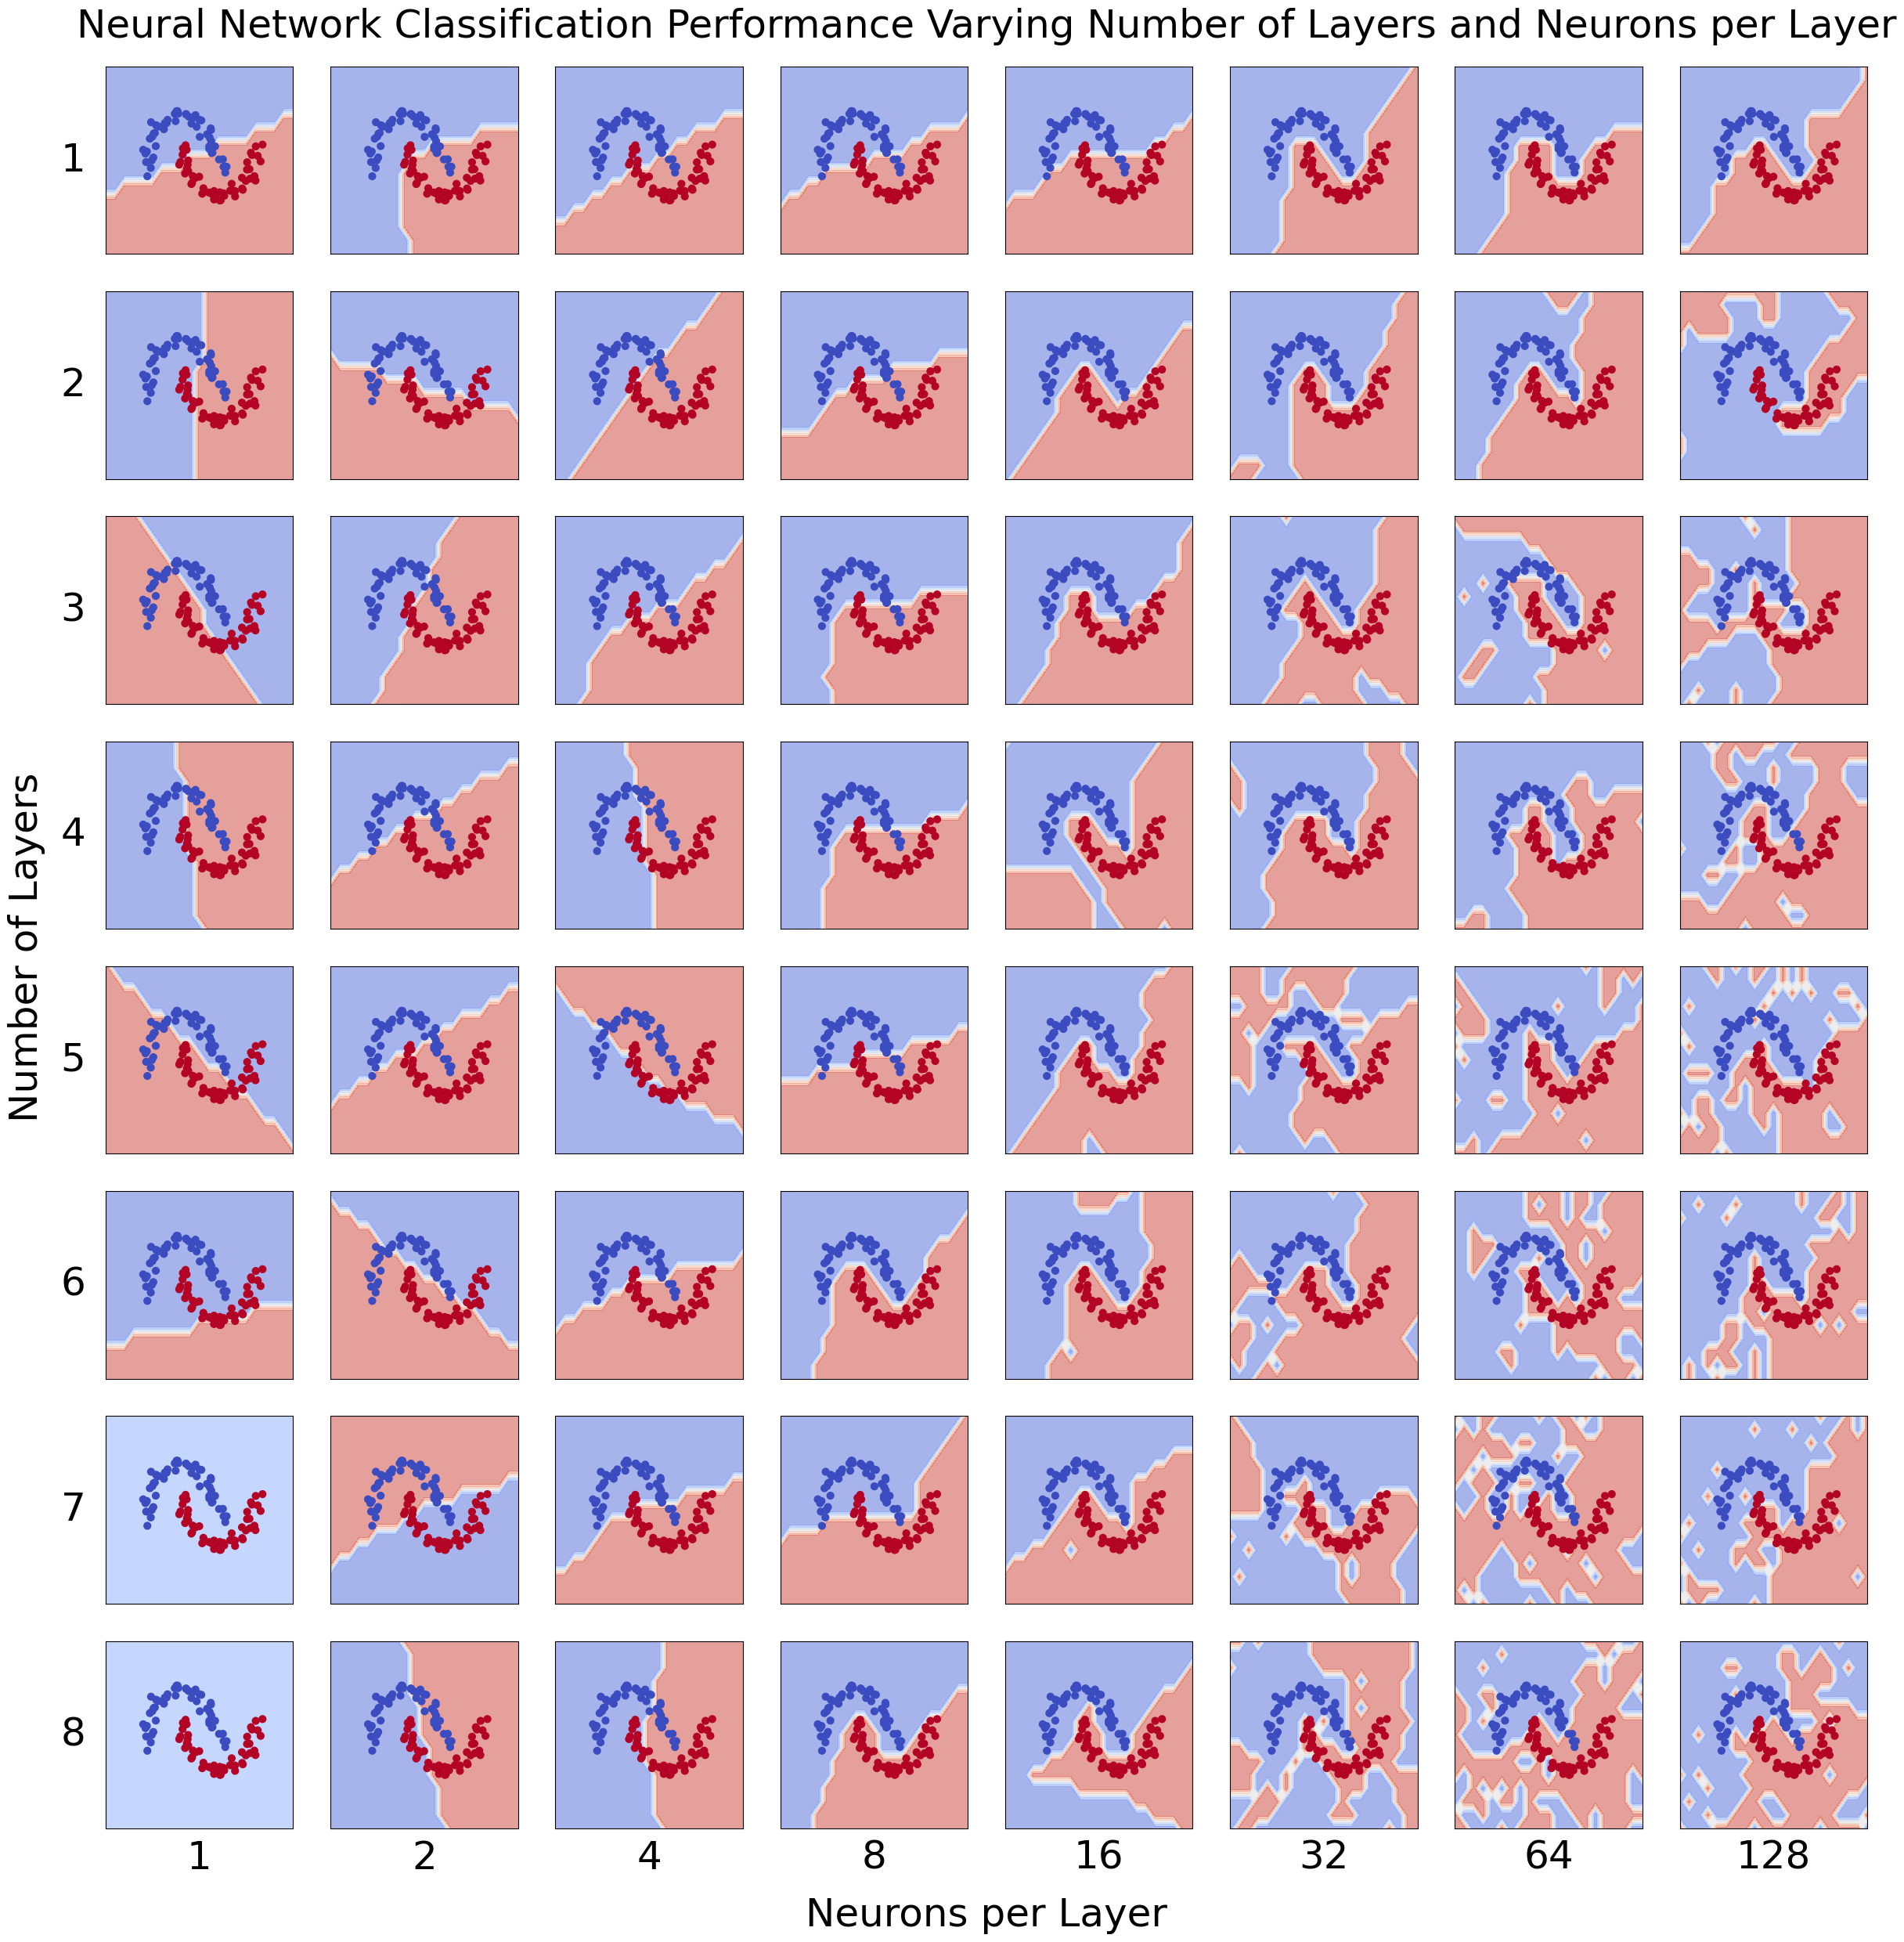

In [77]:
fig, axs = plt.subplots(LAYERS, NEURONS, figsize=(25, 25))
for i in range(LAYERS):
    for j in range(NEURONS):
        plot_subplot(models[i][j], X, axs[i, j], i, j)
plt.subplots_adjust(left=0.05, bottom=0.05, top=0.95, right=0.95)
fig.suptitle('Neural Network Classification Performance Varying Number of Layers and Neurons per Layer', fontsize=36)
fig.text(0.5, 0.0, 'Neurons per Layer', ha='center', fontsize=36)
fig.text(0.0, 0.5, 'Number of Layers', va='center', rotation='vertical', fontsize=36)
plt.show()